In [132]:
!pip3 install numpy
!pip3 install pandas
!pip3 install scipy
!pip3 install matplotlib

In [133]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import datetime
import re

In [134]:
with open('./data/Ireland.txt', encoding="utf8") as f:
    data = f.read().lower()
print(data)

2019 ireland prep
w1d1 - 5/27/19
comp bench - 185x3x12
beltless paused (1” off ground) sumo deadlift - 360x3x5
inverted row - 25lbx5x8
incline dumbbell bench - 55x3x8
football bar curls - 60x3x15 (15lb bar)
w1d2 - 5/28/19
close grip bench - 180x3x7
low bar paused beltless squats - 345x4x3
bulgarian split squats - bwx3x10
hamstring curls - 110x3x12
back extension - bwx4x10
w1d3 - 5/30/19
beltless front squats - 245x3x5
pendlay rows - 165x3x10
inverted rows - 0x4x12
lat pulldown - 50(1), 57.5(3)x4x12
alternating bicep curls - 30x4x12
w1d4 - 5/31/19
comp bench - 225x5x3
beltless conventional deadlift - 365(1), 275(1)x2x8
dips - 45x3x8 - very difficult rpe10 every set
machine chest flys - 130x4x10
incline dumbbell bench - 55x4x10
w1d5 - 6/2/19
tng bench - 185x3x10 - rpe6 sleeved without much leg drive and quality sleep
beltless high bar squat - 275x3x8 - feels very good considering sleep schedule, rpe8 
yates row - 225x2x10
unilateral tricep extension - 27.5x3x15
swiss bar bicep curls - 65

In [135]:
def preprocess(text):
    pattern = r'\(-(\d+)%\)'
    # First, make initial replacements for specific words with hyphens
    text = text.replace('t-spine', 't spine')
    text = text.replace('ez-bar', 'ez bar')
    text = text.replace('single-arm', 'single arm')
    text = text.replace('straight-bar', 'straight bar')
    text = text.replace('snatch-grip', 'snatch grip')
    text = text.replace('single-legged', 'single legged')
    text = text.replace('stiff-legged', 'stiff legged')
    text = text.replace('straight-bar', 'straight bar')
    text = text.replace('close-grip', 'close grip')
    text = text.replace('backoffs', '')
    text = text.replace('paused', 'pause')
    text = text.replace('bench press', 'bench')
    text = text.replace('ohp', 'military press')
    text = text.replace('high bar squat', 'high bar')
    text = text.replace('neutral grip lat pulldown', 'lat pulldown')
    text = text.replace('neutral lat pulldown', 'lat pulldown')
    text = text.replace('close grip lat pulldown', 'lat pulldown')
    text = text.replace('t-bar row', 't bar row')
    text = text.replace('bw', '0')
    text = text.replace('feet-up bench', 'feet up bench')
    text = re.sub(pattern, '', text)
    
    
    # Split the text into lines
    lines = text.split('\n')
    
    # Process each line to replace dashes after the first two
    new_lines = []
    for line in lines:
        parts = line.split('-')
        if len(parts) > 2:
            # Join the first two parts with a dash, and the rest with a slash
            new_line = '-'.join(parts[:2]) + '-' + '/'.join(parts[2:])
        else:
            # No need to replace if there are not more than two parts
            new_line = '-'.join(parts)
        new_lines.append(new_line)
    
    # Return the modified lines joined back into a single string
    return '\n'.join(new_lines)

In [136]:
processed_data = preprocess(data)
print(processed_data)

2019 ireland prep
w1d1 - 5/27/19
comp bench - 185x3x12
beltless pause (1” off ground) sumo deadlift - 360x3x5
inverted row - 25lbx5x8
incline dumbbell bench - 55x3x8
football bar curls - 60x3x15 (15lb bar)
w1d2 - 5/28/19
close grip bench - 180x3x7
low bar pause beltless squats - 345x4x3
bulgarian split squats - 0x3x10
hamstring curls - 110x3x12
back extension - 0x4x10
w1d3 - 5/30/19
beltless front squats - 245x3x5
pendlay rows - 165x3x10
inverted rows - 0x4x12
lat pulldown - 50(1), 57.5(3)x4x12
alternating bicep curls - 30x4x12
w1d4 - 5/31/19
comp bench - 225x5x3
beltless conventional deadlift - 365(1), 275(1)x2x8
dips - 45x3x8 - very difficult rpe10 every set
machine chest flys - 130x4x10
incline dumbbell bench - 55x4x10
w1d5 - 6/2/19
tng bench - 185x3x10 - rpe6 sleeved without much leg drive and quality sleep
beltless high bar - 275x3x8 - feels very good considering sleep schedule, rpe8 
yates row - 225x2x10
unilateral tricep extension - 27.5x3x15
swiss bar bicep curls - 65x5x10 ( 15

In [137]:
def validate(date_text):
    try:
        parts = date_text.split('-')
        if 0 <= 1 < len(parts):
            # Parse date checks if it's a valid date in the MM/DD/YY format
            datetime.datetime.strptime(parts[1].strip(), '%m/%d/%y')
            return True
    except ValueError:
        return False

In [138]:
print(validate('W5D1 - 6/24/19'))                           # Expected = True
print(validate('Alternating Hammer Curls - 30x3x15'))       # Expected = False

True
False


In [139]:
def dynamic_transform_weights(weight_string):
    # Split the string into parts based on commas to handle multiple weights
    weight_parts = [part.strip() for part in weight_string.split(',')]

    # Initialize a list to hold transformed parts
    transformed_parts = []

    # Check the format of the last part to determine if it dictates shared repetitions
    last_part_components = weight_parts[-1].split('x')

    # Check if shared repetitions should be applied
    if len(last_part_components) == 2 and last_part_components[1].isdigit() and all('x' not in part for part in weight_parts[:-1]):
        # The last part indicates shared repetitions across weights
        reps = last_part_components[1]
        for part in weight_parts[:-1]:
            transformed_parts.append(f"{part}x{reps}")
        # Include the last weight with the shared reps
        last_weight = last_part_components[0]
        transformed_parts.append(f"{last_weight}x{reps}")
    else:
        # No shared repetitions, output each part as is
        transformed_parts = weight_parts

    return ', '.join(transformed_parts)

In [140]:
print(dynamic_transform_weights('395,410,455x3'))        # Expected = 395x3, 410x3, 455x3
print(dynamic_transform_weights('410x3x3'))              # Expected = 410x3x3
print(dynamic_transform_weights('365x2x6,315x6@6'))      # Expected = 365x2x6,315x6@6
print(dynamic_transform_weights('45x15, 95x10, 135x8, \
                                185x5, 225x1, \
                                235x3, 242.5x3,250x3'))  # Expected = 45x15, 95x10, 135x8, 185x5, 225x1, 235x3, 242.5x3, 250x3

395x3, 410x3, 455x3
410x3x3
365x2x6, 315x6@6
45x15, 95x10, 135x8, 185x5, 225x1, 235x3, 242.5x3, 250x3


In [141]:
def parse_exercise_data(data):
    # Initialize lists to store weights, sets, reps, and optionally RPE
    weights = []
    sets = []
    reps = []
    rpes = []  # List to store RPE values

    # Iterate over each sublist in the main list
    for sublist in data:
        for item in sublist:
            # Clean up any leading/trailing whitespace
            item = item.strip()

            # Handle RPE if present
            if '@' in item:
                item, rpe = item.split('@')
                rpes.append(float(rpe))  # Convert RPE to float in case of decimal RPE values
            else:
                rpes.append(None)  # Append None when RPE is not specified

            # Split the string at 'x' to extract components
            parts = item.split('x')

            # Determine how to parse the item based on the number of parts found
            if len(parts) == 3:
                weights.append(float(parts[0]))
                sets.append(int(parts[1]))
                reps.append(int(parts[2]))
            elif len(parts) == 2:
                weights.append(float(parts[0]))
                sets.append(1)  # Default value for sets
                reps.append(int(parts[1]))
            elif len(parts) == 1 and parts[0].replace('.', '', 1).isdigit():
                # Handle numeric input as weights with default sets and reps
                weights.append(float(parts[0]))
                sets.append(1)  # Default sets
                reps.append(1)  # Default reps
            else:
                # Log unexpected formats
                print(f"Unexpected format: {item}")

    return weights, sets, reps, rpes

In [142]:
print(parse_exercise_data([['245x6', ' 225x2x6']]))
print(parse_exercise_data([['585x1@9']]))

([245.0, 225.0], [1, 2], [6, 6], [None, None])
([585.0], [1], [1], [9.0])


In [149]:
lines = processed_data.strip().split('\n')
workout_log = {}
current_date = None

for line in lines:
    if validate(line):
        current_date = line.split("-")[1]
        workout_log[current_date] = []
    elif current_date:
        workout_log[current_date].append(line.strip())

# Data structure to load into DataFrame
df_data = []
something = []

for date, contents in workout_log.items():
    for content in contents:
        # print(contents[0])
        items = content.split('-')
        if len(items) >= 3:  # Ensure there are enough parts
            exercise = items[0].strip()
            weights_sets_reps = dynamic_transform_weights(items[1].strip()).split(sep=',')
            notes = '-'.join(items[2:]).strip()  # Join any remaining parts as notes
            weights, sets, reps, rpe = (parse_exercise_data(([weights_sets_reps])))
            df_data.append([date, exercise, weights, sets, reps, rpe, notes])

In [150]:
df = pd.DataFrame(df_data, columns=["Date", "Exercise", "Weights", "Sets", "Reps", "RPE", "Notes"])

In [151]:
df.head(100)

,Date,Exercise,Weights,Sets,Reps,RPE,Notes
0,5/31/19,dips,[45.0],[3],[8],[None],very difficult rpe10 every set
1,6/2/19,tng bench,[185.0],[3],[10],[None],rpe6 sleeved without much leg drive and qualit...
2,6/2/19,beltless high bar,[275.0],[3],[8],[None],"feels very good considering sleep schedule, rpe8"
3,6/3/19,comp bench,[195.0],[3],[10],[None],rpe8 good and smooth
4,6/3/19,pause beltless sumo deadlift,"[425.0, 375.0]","[1, 4]","[1, 5]","[None, None]",smooth but heavy
...,...,...,...,...,...,...,...
95,8/28/19,comp bench,"[285.0, 220.0]","[1, 4]","[1, 7]","[9.5, None]","single was smooth and felt solid, sets were sm..."
96,8/29/19,comp bench,[235.0],[5],[5],[None],smooth and doable
97,8/29/19,hamstring curl,[110.0],[3],[6],[None],"extreme discomfort, obviously something is wrong"
98,9/2/19,comp squat,"[380.0, 325.0]","[3, 2]","[3, 5]","[None, None]",focused on getting confidence back on squats


C:\Users\Grant\AppData\Local\Temp\ipykernel_1964\1927701072.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates = pd.to_datetime(dates)
C:\Users\Grant\AppData\Local\Temp\ipykernel_1964\1927701072.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates2 = pd.to_datetime(dates2)
C:\Users\Grant\AppData\Local\Temp\ipykernel_1964\1927701072.py:57: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(dates2, weights2, c=reps2, cmap=cmap, norm=norm, s=100, edgecolor='k', marker='+')


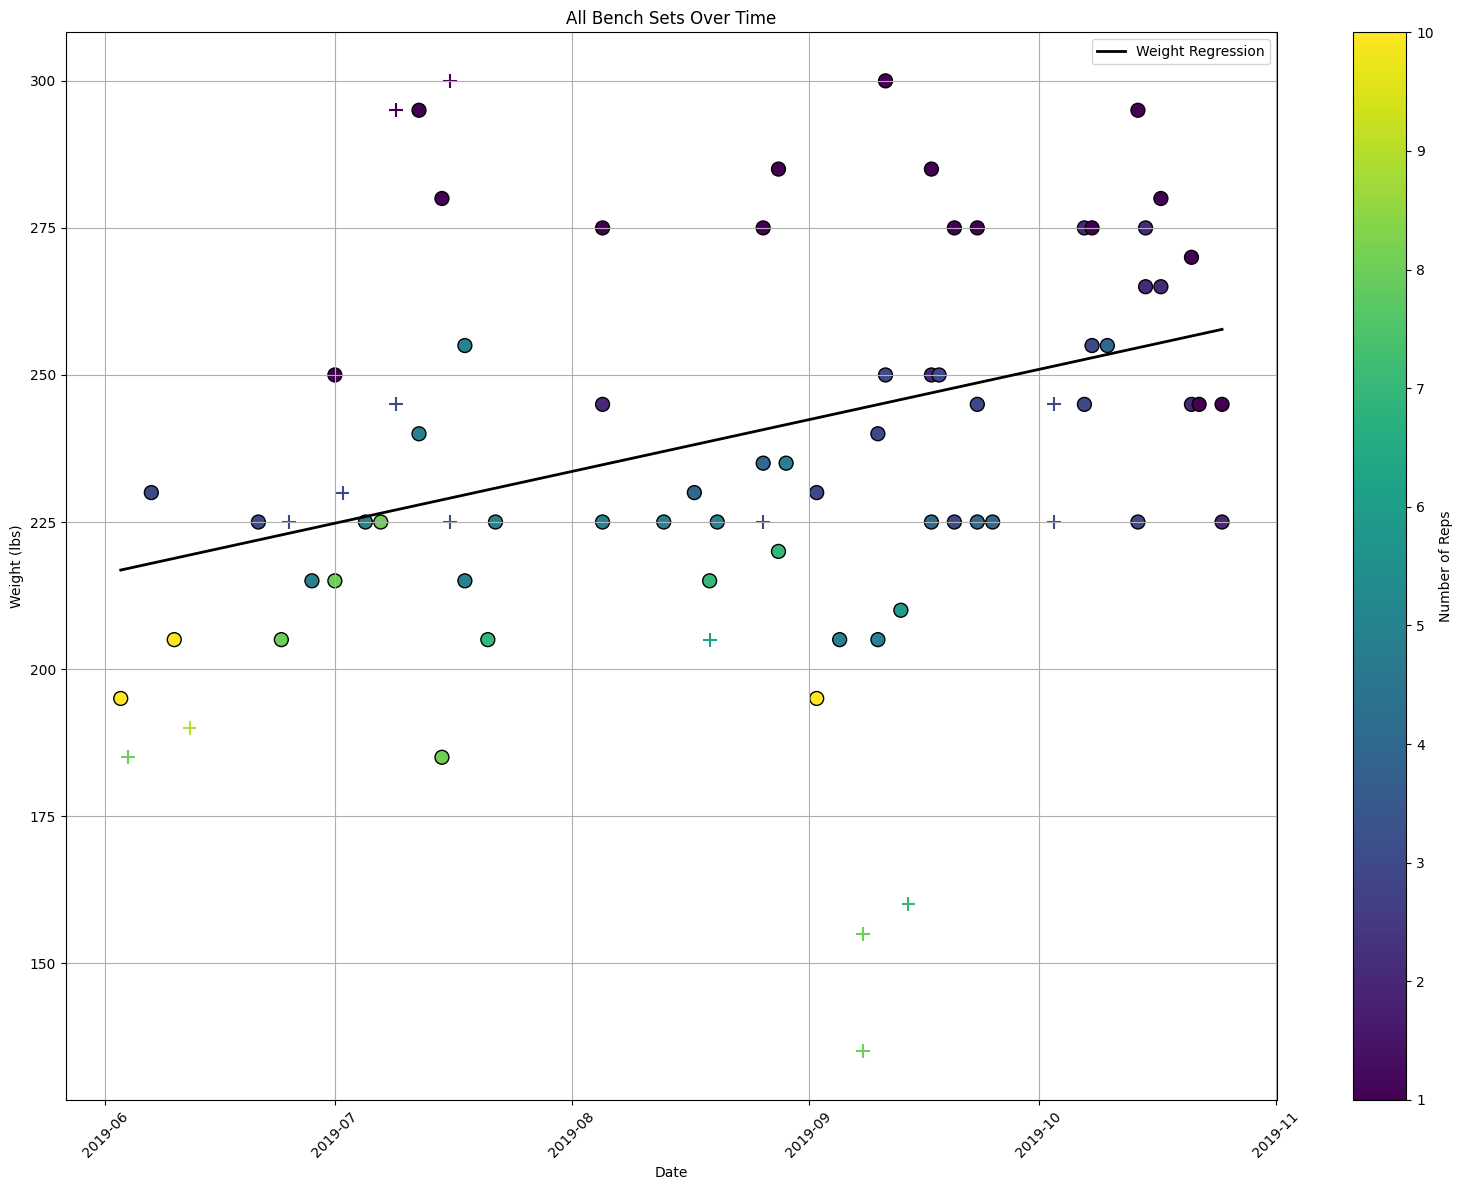

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import date2num

# Assuming df is your DataFrame and it has been populated as per previous examples

# Filter the DataFrame for 'bench' related exercises, assuming all variations contain "comp bench"
bench_df = df[df['Exercise'].str.contains('comp bench', case=False, na=False)]
incline_df = df[df['Exercise'].str.contains('close grip', case=False, na=False)]

# Prepare lists to store plot data
dates = []
weights = []
reps = []

dates2 = []
weights2 = []
reps2 = []

# Iterate over the filtered DataFrame
for index, row in bench_df.iterrows():
    # Check each weight and corresponding rep count
    for weight, rep in zip(row['Weights'], row['Reps']):
        if rep > 0 and weight > 150:  # Only consider reps greater than zero
            dates.append(row['Date'])
            weights.append(weight)
            reps.append(rep)

# Iterate over the filtered DataFrame
for index, row in incline_df.iterrows():
    # Check each weight and corresponding rep count
    for weight, rep in zip(row['Weights'], row['Reps']):
        dates2.append(row['Date'])
        weights2.append(weight)
        reps2.append(rep)

# Convert dates for plotting
dates = pd.to_datetime(dates)
# print('before', inclineDates)
dates2 = pd.to_datetime(dates2)
# print('after', inclineDates)
date_nums = date2num(dates)  # Convert dates to ordinal numbers for regression

# Use a colormap to vary colors based on the number of reps
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(min(reps), max(reps))

# Compute linear regression
slope, intercept = np.polyfit(date_nums, weights, 1)
regression_line = slope * date_nums + intercept

# Plotting
plt.figure(figsize=(16, 12))
scatter = plt.scatter(dates, weights, c=reps, cmap=cmap, norm=norm, s=100, edgecolor='k')
plt.plot(dates, regression_line, color='black', linewidth=2, label='Weight Regression')  # Add regression line
plt.scatter(dates2, weights2, c=reps2, cmap=cmap, norm=norm, s=100, edgecolor='k', marker='+')
plt.title('All Bench Sets Over Time')
plt.xlabel('Date')
plt.ylabel('Weight (lbs)')
plt.colorbar(scatter, label='Number of Reps')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()